In [27]:
# import modules
from qutip import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import reduce
import importlib
import time
import os
import sys

# locate directory containing scripts 
current_directory = os.getcwd() 
src_directory = os.path.dirname(current_directory) + '/src'
sys.path.append(src_directory)

# import custom module
import spin_chain, simulate_algorithm
importlib.reload(spin_chain)
importlib.reload(simulate_algorithm)

# define identity for qubits 
I2 = qeye(2)

# define Pauli matrices and constants
σ_x = sigmax()
σ_y = sigmay()
σ_z = sigmaz()
π = np.pi

# font specs for plots
%matplotlib inline
mpl.rcParams["font.family"] = "STIXGeneral"
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.size"] = "14"

## $\hat{H}_2 = X_1 X_2 + Y_1 Y_2 + \lambda Z_1 Z_2 $

In [28]:
# specify parameters of 2-site spin chain
N2 = 2
Jx = 1
Jy = 1
Jz = 1
periodic_bc = False
tolerance = 1e-12

# calculate spin chain quantities
# calculate spin chain quantities
H2, H2_list, eigenstates2, eigenvalues2, min_eigenvalue2, ρ_ground_state2 = \
    spin_chain.properties(N2, Jx, Jy, Jz, periodic_bc, tolerance)

In [29]:
# define singlet and triplet states
S = eigenstates2[0]
T0 = eigenstates2[3]
Tn1 = eigenstates2[2]
T1 = eigenstates2[1]

# create basis of singlets and triplets
ST_basis = [S, Tn1, T0, T1]

# create matrix with S, Tn1, T0 and T1 as column vectors 
ST_matrix = Qobj(np.hstack([eigenstate.full() for eigenstate in ST_basis]))
display(ST_matrix)

# eigenvalues for 2-site spin chain
display(eigenvalues2)

Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.          0.          0.          1.        ]
 [-0.70710678  0.          0.70710678  0.        ]
 [ 0.70710678  0.          0.70710678  0.        ]
 [ 0.          1.          0.          0.        ]]

array([-3.,  1.,  1.,  1.])

# $\hat{H}_6 = \sum_{j = 1}^{6} X_j X_{j+1} + Y_j Y_{j+1} + \lambda Z_j Z_{j+1} $

In [30]:
# specify parameters of spin chain 
N6 = 6
Jx = 1
Jy = 1
Jz = 1
periodic_bc = True
tolerance6 = 1e-12

# calculate spin chain quantities
H6, H6_list, eigenstates6, eigenvalues6, E_0, ρ_ground_state6 = \
    spin_chain.properties(N6, Jx, Jy, Jz, periodic_bc, tolerance)
spin_chain.orthonormal_eigenstates(eigenstates6, tolerance6)

Your eigenstates form an orthonormal basis!


# $\text{Theoretical Projection Fidelities }$

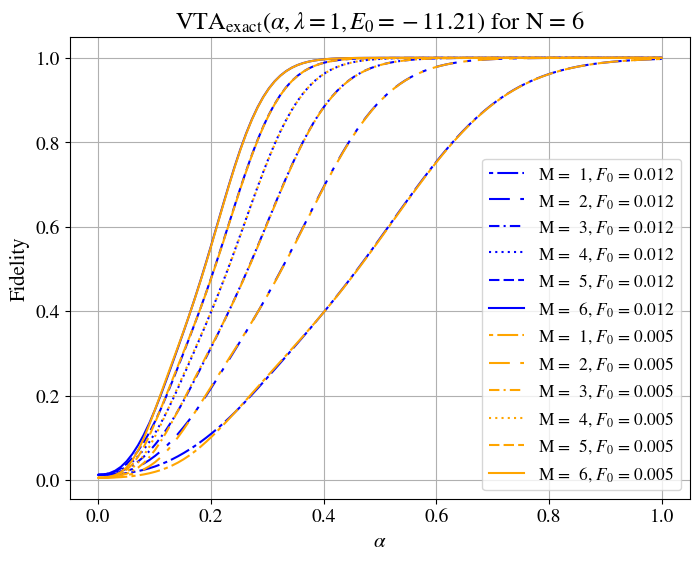

In [40]:
N_cavities = 6
N_qubits = 6
m_start = 1
m_stop = 6
α_start = 0
α_end = 1
α_steps = 100
num_states = 2
cutoff = 'N/A'
save_file = False

Ψ0_list, ψ0_list  = simulate_algorithm.generate_initial_states(N_cavities, N_qubits, num_states, cutoff)
fidelity_array_list = simulate_algorithm.plot_exact_fidelity( \
                        N_cavities, α_start, α_end, α_steps, E_0, m_start, m_stop, \
                        N_qubits, Jx, Jy, Jz, periodic_bc, tolerance, ψ0_list, save_file)

In [34]:
Ψ0_list

NameError: name 'Ψ0_list' is not defined

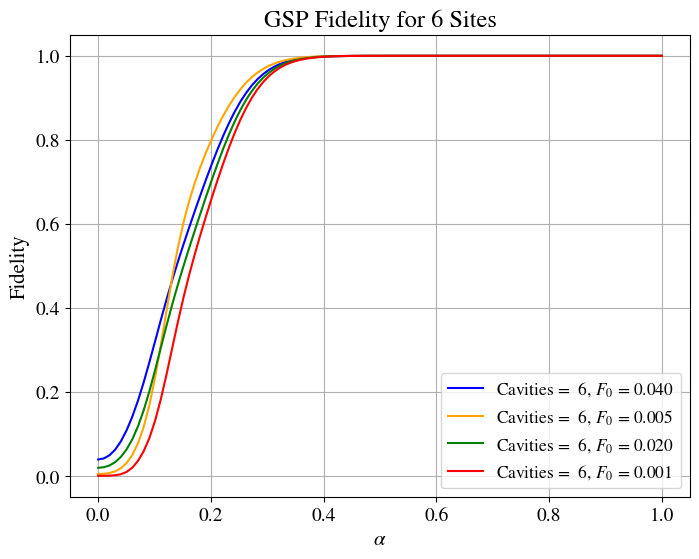

In [18]:
N_cavities = 6
N_qubits = 6
m_start = 6
m_stop = 6
α_start = 0
α_end = 1
α_steps = 100
num_states = 4
cutoff = 9
save_file = False

initial_state_list = spin_chain.generate_initial_states(N_cavities, N_qubits, num_states, cutoff)
spin_chain.plot_fidelity(N_cavities, N_qubits, eigenvalues6, eigenstates6, m_start, m_stop, \
                         α_start, α_end, α_steps, initial_state_list, cutoff, save_file)

# $\text{Simulated Projection Fidelities (Eigendecomposition) }$

In [19]:
def eigendecomp_spin_operators(N, ST_basis):
    
    '''
    function to find the global eigenkets for blue and red bonds as well
    as the spectrum of each local 2-site Hamiltonian in the basis of these
    global eigenkets
    '''
    
    # collect indices for H_ik Hamiltonians which will be used to convert 
    # blue global eigenkets to red global eigenkets
    H_ik_indices = [(2 + i, N - i) for i in range(0, int(N/2) - 1)]

    # collect all H_ik matrices, which are Hamiltonians containing 
    # XX + YY + ZZ at indices i and k specified by each tuple in H_SWAP_indices
    H_ik_list = []
    for indices_tuple in H_ik_indices:

        # collect at which sites we will insert Pauli matrices
        site1 = indices_tuple[0]
        site2 = indices_tuple[1]

        # define list of identity operators and insert Pauli matrices
        # at sites specified by indices_tuple
        op_list = [qeye(2)]*N
        op_list[site1 - 1] = σ_x
        op_list[site2 - 1] = σ_x
        HX_couplings = tensor(op_list)
        op_list[site1 - 1] = σ_y
        op_list[site2 - 1] = σ_y
        HY_couplings = tensor(op_list)
        op_list[site1 - 1] = σ_z
        op_list[site2 - 1] = σ_z
        HZ_couplings = tensor(op_list) 

        # append H_SWAP = HX_couplings + HY_couplings + HZ_couplings to H_ik_list
        H_ik_list.append(HX_couplings + HY_couplings + HZ_couplings)

    # collect product of SWAP matrices that will convert red eigenkets to blue eigenkets
    I = tensor([qeye(2)]*N)
    dim = 2**N
    SWAP_operator = Qobj(reduce(lambda x,y: x*y, \
                                [(H_ik + I)/2 for H_ik in H_ik_list]), dims = [[dim], [dim]])

    # construct global eigenkets for red and blue bonds for N sites
    blue_mpsN = [Qobj(eigvec) for eigvec in reduce(np.kron, [ST_basis]*(int(N/2)))]
    red_mpsN = [SWAP_operator(Qobj(eigvec)) for eigvec in reduce(np.kron, [ST_basis]*(int(N/2)))]
    
    # initialize empty list which will contain the spectrum of each local Hamiltonian 
    # in the basis of the blue and red global eigenkets
    H_local_spectrum_list = []

    # find spectra of all 2-site Hamiltonians
    for i in range(1, N+1, 2):

        # compute spectrum from tensor products of index 1 to i 
        Hij_spectrum_1i = np.tile(eigenvalues2, 2**(i-1))

        # compute spectrum of tensor products of inex 1 to N, i.e., the full spectrum
        Hij_spectrum_1N = np.repeat(Hij_spectrum_1i, np.ceil(2**(N - i - 1)))

        # append to Hij_spectrum_list
        H_local_spectrum_list.append(Hij_spectrum_1N)

    # extra spectra for blue and red bonds according to previous ordering of eigenkets
    blue_spectraN = H_local_spectrum_list
    red_spectraN = H_local_spectrum_list[::-1]

    return blue_spectraN, blue_mpsN, red_spectraN, red_mpsN

In [20]:
def reconstruct_HN_list(HN_list, blue_spectraN, blue_mpsN, red_spectraN, red_mpsN):

    '''
    reconstruct list of local Hamiltonians from parameters yielded by the eigendecomposition 
    of all red and blue bonds
    '''

    # calculate the number of sites in spin chain
    N = 2*len(blue_spectraN)

    # reconstruct lists of Hamiltonians corresponding to blue and red bonds
    HN_blue_list_reconstructed = [sum([λ*vec*vec.dag() for λ, vec in \
                                  zip(blue_spectraN[i], blue_mpsN)]) for i in range(int(N/2))]
    HN_red_list_reconstructed = [sum([λ*vec*vec.dag() for λ, vec in \
                                 zip(red_spectraN[i], red_mpsN)]) for i in range(int(N/2))]

    # interleave HN_blue_list and HN_red_list to create an ordered list of local Hamiltonians 
    HN_list_reconstructed = np.concatenate((HN_blue_list_reconstructed, HN_red_list_reconstructed))
    HN_list_reconstructed[::2] = HN_blue_list_reconstructed
    HN_list_reconstructed[1::2] = HN_red_list_reconstructed 

    # extract lists of blue and red Hamiltonians from HN_list
    HN_blue_list = HN_list[::2]
    HN_red_list = HN_list[1::2]

    # verify that HN_list == HN_list_reconstructed using two methods
    verification1 = np.allclose(HN_list, HN_list_reconstructed, atol = 1e-12)

    # use for loop to check whether HN_list[i] == HN_list_reconstructed[i]
    H_tot_boolN = []
    for Hb1, Hb2, Hr1, Hr2 in zip(HN_blue_list_reconstructed, HN_blue_list, \
                                  HN_red_list_reconstructed, HN_red_list):

        H_tot_boolN.append(np.allclose(Hb1, Hb2, atol = 1e-12))
        H_tot_boolN.append(np.allclose(Hr1, Hr2, atol = 1e-12))

    verification2 = all(H_tot_boolN)

    # print whether both methods of verifying equality between Hamiltonians 
    # yield True or False
    if verification1 and verification2: 
        print('Hamiltonians are the same!')
    else: 
        print('Hamiltonians are different')

In [21]:
# verify eigendecomposition can reconstruct list of local Hamiltonians for N = 6
N = 6
blue_spectra6, blue_mps6, red_spectra6, red_mps6 = eigendecomp_spin_operators(N, ST_basis)
reconstruct_HN_list(H6_list, blue_spectra6, blue_mps6, red_spectra6, red_mps6)

Hamiltonians are the same!


In [24]:
# define local Hamiltonians 
A = H6_list[0]
B = H6_list[1]
C = H6_list[2]
D = H6_list[3]
E = H6_list[4]
F = H6_list[5]

# collect an ordered list of all the spectra of the local Hamiltonians
spectra6 = blue_spectra6 + red_spectra6
spectra6[::2] = blue_spectra6
spectra6[1::2] = red_spectra6

# define lists of eigenvalues for spin operators A, B, C and D that incorporate the 
# translation -E_0/4 
a = spectra6[0] - E_0/6
b = spectra6[1] - E_0/6 
c = spectra6[2] - E_0/6
d = spectra6[3] - E_0/6
e = spectra6[4] - E_0/6
f = spectra6[5] - E_0/6

# define all the bras and kets of the blue and red global eigenstates
μ6_kets = blue_mps6
μ6_bras = [eigvec.dag() for eigvec in μ6_kets]
ν6_kets = red_mps6
ν6_bras = [eigvec.dag() for eigvec in ν6_kets]

In [25]:
# define Gaussian weight tensor
# define a Gaussian weight tensor
def W6(α, k0, k1, k2, k3, k4, k5): 
    return np.exp(-((α**2)/2)*((a[k0] + b[k1] + c[k2] + d[k3] + e[k4] + f[k5])**2))

In [ ]:
VTA6 = Qobj(np.zeros((16, 16)))
start_time = time.time()
for k3 in range(len(d)):
    for k2 in range(len(c)):
        for k1 in range(len(b)):
            for k0 in range(len(a)):
                VTA4_2 += W4_tensor[k0, k3, k2, k1]*W4_tensor[k0, k1, k2, k3] * \
                         W4_tensor[k2, k1, k0, k3]*W4_tensor[k2, k3, k0, k1] * \
                         (ν4_bras[k3]*μ4_kets[k2])*(μ4_bras[k2]*ν4_kets[k1])*(ν4_bras[k1]*μ4_kets[k0]) * \
                         ν4_kets[k3]*μ4_bras[k0]      
print("%s seconds" % (time.time() - start_time))

In [ ]:
VTA6 = sum(
            W4_tensor[k0, k3, k2, k1]*W4_tensor[k0, k1, k2, k3] * \
            W4_tensor[k2, k1, k0, k3]*W4_tensor[k2, k3, k0, k1] * \
            (ν4_bras[k3]*μ4_kets[k2])*(μ4_bras[k2]*ν4_kets[k1]) * \
            (ν4_bras[k1]*μ4_kets[k0])*(ν4_kets[k3]*μ4_bras[k0])  
            for k3 in range(len(d)) \
            for k2 in range(len(c)) \
            for k1 in range(len(b)) \
            for k0 in range(len(a)) \
            )

In [143]:
VTA4_2 = Qobj(np.zeros((16, 16)))
start_time = time.time()
for k3 in range(len(d)):
    for k2 in range(len(c)):
        for k1 in range(len(b)):
            for k0 in range(len(a)):
                VTA4_2 += W4_tensor[k0, k3, k2, k1]*W4_tensor[k0, k1, k2, k3] * \
                         W4_tensor[k2, k1, k0, k3]*W4_tensor[k2, k3, k0, k1] * \
                         (ν4_bras[k3]*μ4_kets[k2])*(μ4_bras[k2]*ν4_kets[k1])*(ν4_bras[k1]*μ4_kets[k0]) * \
                         ν4_kets[k3]*μ4_bras[k0]      
print("%s seconds" % (time.time() - start_time))

14.85303807258606 seconds


In [195]:
start_time = time.time()
VTA4_3 = sum(
            W4_tensor[k0, k3, k2, k1]*W4_tensor[k0, k1, k2, k3] * \
            W4_tensor[k2, k1, k0, k3]*W4_tensor[k2, k3, k0, k1] * \
            (ν4_bras[k3]*μ4_kets[k2])*(μ4_bras[k2]*ν4_kets[k1]) * \
            (ν4_bras[k1]*μ4_kets[k0])*(ν4_kets[k3]*μ4_bras[k0])  
            for k3 in range(len(d)) \
            for k2 in range(len(c)) \
            for k1 in range(len(b)) \
            for k0 in range(len(a)) \
            )
print("%s seconds" % (time.time() - start_time))

14.271757125854492 seconds


In [146]:
display(VTA4_1 == VTA4_2 == VTA4_3)
VTA = Qobj(VTA4_3, dims = [[2]*4, [2]*4])

True

In [317]:
def compute_VTA_list(α_start, α_end, α_steps):
    
    # start the timer for the operation 
    start_time = time.time()
    
    α_array = np.linspace(α_start, α_end, α_steps)
    
    # calculate the vacuum transition amplitude for N = 4
    VTA_list = []
    for α in α_array: 
        VTA = sum(
                W4(α, k0, k3, k2, k1)*W4(α, k0, k1, k2, k3) * \
                W4(α, k2, k1, k0, k3)*W4(α, k2, k3, k0, k1) * \
                (ν4_bras[k3]*μ4_kets[k2])*(μ4_bras[k2]*ν4_kets[k1]) * \
                (ν4_bras[k1]*μ4_kets[k0])*(ν4_kets[k3]*μ4_bras[k0])  
                for k3 in range(len(d)) \
                for k2 in range(len(c)) \
                for k1 in range(len(b)) \
                for k0 in range(len(a)) \
                )
        # adjust dimensions of VTA and append to VTA_list
        VTA_adjusted = Qobj(VTA, dims = [[2]*4, [2]*4])
        VTA_list.append(VTA_adjusted)
        
        
    print("%s seconds" % (time.time() - start_time))
    return VTA_list

In [ ]:
VTA_list = compute_VTA_list(α_start, α_end, α_steps)

In [482]:
VTA_list_M4 = VTA_list

In [368]:
# create array over which to sweep α
α_start = 0
α_end = 0.5
α_steps = 100
m_start = 4
m_stop = 4
r = 1

In [494]:
def plot_GSP_data(ψ0_list, VTA_list, α_start, α_end, α_steps, m_start, m_stop, save_file): 
    
    # define array over which we will plot α
    α_array = np.linspace(α_start, α_end, α_steps)

    # define list of colors to use for plots 
    colors = ['blue', 'orange', 'green','red', 'purple', 'black', 'pink', 'gray', 'cyan', 'magenta']
    
    # compute list of projection fidelity for VTA_list for all initial states in ψ0_list
    GSP_fidelity_array_list = [[expect(ρ_ground_state4, (VTA*ψ0).unit()) for VTA in VTA_list] \
           for ψ0 in ψ0_list]

    # generate custom linestyles to use if we are projecting 4 or more cavities onto vacuum
    dashed_list = [(None, None), (5, 2), (1, 2), (5, 2, 1, 2), (10, 5, 2, 5), \
                   (2, 2, 10, 2), (5, 2, 10, 2, 5, 2), (15, 5, 5, 5), (2, 5, 10, 5)]

    fig, ax = plt.subplots(figsize=(8, 6))

    # graph the theoretical projection of all initial states onto the true ground state 
    for i, fidelity_array in enumerate(GSP_fidelity_array_list): 
        ax.plot(α_array, fidelity_array, label=f'Trotterized, M = 4, $F_0$ = {fidelity_array[0] : .3f}', \
                color=colors[i], linestyle='-')

    ax.set_xlabel(r'$\alpha$', fontsize=15)
    ax.set_ylabel('Fidelity', fontsize=15)
    ax.set_title(f'Trotterized GSP with r = {1} for N = 4', fontsize=17.5)  
    ax.legend(fontsize = 12.5)
    ax.grid(True)
    
    if save_file: 
    
        # define which folder subfolder in /data to store the image
        if N_qubits == 2: 
            site_folder = 'two_sites'
        elif N_qubits == 3: 
            site_folder = 'three_sites'
        elif N_qubits == 4: 
            site_folder = 'four_sites'
        elif N_qubits == 5: 
            site_folder = 'five_sites'

        # calculate number of states that were simulated
        num_states = len(ψ0_list)

        if m_start != m_stop: 

            # create name for png file 
            filename = f'/Users/lukebell/Documents/boson_gang/data/{site_folder}/simulated_' \
                        f's{num_states}_m{m_start}{m_stop}_r{r}.png'

            # Check if the file already exists
            if os.path.exists(filename):
                # If it exists, remove it
                os.remove(filename)

            # save figure 
            plt.savefig(filename)

        elif m_start == m_stop: 
            
            # create name for png file 
            filename = f'/Users/lukebell/Documents/boson_gang/data/{site_folder}/simulated_' \
                        f's{num_states}_m{m_start}_r{r}.png'

        # Check if the file already exists
        if os.path.exists(filename):
            # If it exists, remove it
            os.remove(filename) 

        # save figure 
        plt.savefig(filename)

In [515]:
N_cavities = 0 
N_qubits = 4
cutoff = 0 
α_start = 0
α_end = 0.5
α_steps = 100
m_start = 4
m_stop = 4
r = 1
save_file = True
num_states = 4

# define initial states
ψ0_list = spin_chain.generate_initial_states(N_cavities, N_qubits, num_states, cutoff)

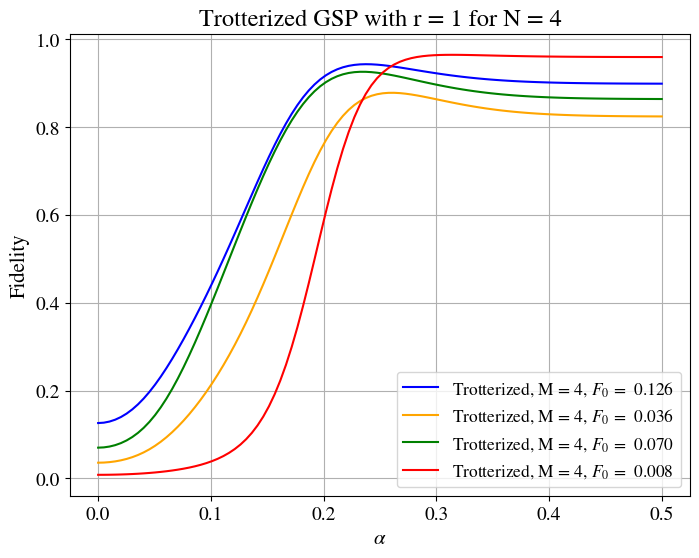

In [516]:
plot_GSP_data(ψ0_list, VTA_list, α_start, α_end, α_steps, m_start, m_stop, save_file)